In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1' # to disable GPU
import featureEng as fe
import processStocks as ps
import getStocks
import visualize
import predicts
import pandas as pd
import TS_LSTM as ts_lstm

pd.options.display.max_columns = 999
pd.options.display.max_rows = 999

C:\Users\hende\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# view tenslow enabled devices
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 691821314675312959
]


# User parameters

In [3]:
ticker = 'amd'.upper()
n_in = 100 # number of historical days to input
n_out = 1 # days into future to predict
target = 'd1close'

# Load Data
### Several methods available here:
* Load a single stock
* get a refresh of the stock
* load a single stock as the target while using many other stocks as additional features

In [4]:
# load dataset
# dataset = getStocks.get_single(ticker=ticker, save=True)
dataset = getStocks.load_single(ticker)
#dataset = getStocks.join_tgt_spt(target_ticker=ticker.upper(), number_spt=20)
dataset.reset_index(level=0, inplace=True)
dataset.rename(columns=lambda x: x.replace(' ',''),inplace=True)

Loaded AMD


# Prepare Data for LSTM

In [5]:
# using default options
'''
ts_data=ts_lstm.ts_data.default_prep(n_in=n_in, n_out=n_out, 
                      ticker=ticker,target=target,
                      rawData=dataset)
'''

ts_data = ts_lstm.ts_data(n_in=n_in, n_out=n_out, 
                      ticker=ticker,target=target,
                      rawData=dataset)
ts_data.eng_features(derivate=True, weekdays=False)
ts_data.roll_data()
ts_data.tscv(train=0.99)

T:\Dropbox\Projects\LSTM-forecast\src\TS_LSTM.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.data.drop('Date', axis=1, inplace=True)


# Build LSTM Architecture

In [6]:
ts_model = ts_lstm.build_model(ts_data, 
                               inlayer=int(ts_data.train_X.shape[-1])*2,
                               hiddenlayers=0,
                               loss_function='mean_squared_error',
                               dropout=0.05,
                               activation='tanh')

Compilation Time :  0.023294925689697266
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 22)                2992      
_________________________________________________________________
dropout_1 (Dropout)          (None, 22)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 23        
Total params: 3,015
Trainable params: 3,015
Non-trainable params: 0
_________________________________________________________________


# Fit model

In [7]:
history = ts_model.fit(ts_data.train_X, ts_data.train_y, 
                    epochs=50, 
                    batch_size=1024, 
                    validation_data=(ts_data.test_X, ts_data.test_y), 
                    verbose=2, 
                    shuffle=False)

Train on 9331 samples, validate on 95 samples
Epoch 1/50
 - 2s - loss: 0.4498 - val_loss: 0.3251
Epoch 2/50
 - 1s - loss: 0.4238 - val_loss: 0.3015
Epoch 3/50
 - 1s - loss: 0.4066 - val_loss: 0.2836
Epoch 4/50
 - 1s - loss: 0.3896 - val_loss: 0.2675
Epoch 5/50
 - 1s - loss: 0.3776 - val_loss: 0.2529
Epoch 6/50
 - 1s - loss: 0.3610 - val_loss: 0.2400
Epoch 7/50
 - 1s - loss: 0.3489 - val_loss: 0.2283
Epoch 8/50
 - 1s - loss: 0.3350 - val_loss: 0.2180
Epoch 9/50
 - 1s - loss: 0.3300 - val_loss: 0.2087
Epoch 10/50
 - 1s - loss: 0.3219 - val_loss: 0.2004
Epoch 11/50
 - 1s - loss: 0.3137 - val_loss: 0.1932
Epoch 12/50
 - 1s - loss: 0.3089 - val_loss: 0.1867
Epoch 13/50
 - 1s - loss: 0.3022 - val_loss: 0.1811
Epoch 14/50
 - 1s - loss: 0.2970 - val_loss: 0.1763
Epoch 15/50
 - 1s - loss: 0.2901 - val_loss: 0.1720
Epoch 16/50
 - 1s - loss: 0.2906 - val_loss: 0.1683
Epoch 17/50
 - 1s - loss: 0.2863 - val_loss: 0.1651
Epoch 18/50
 - 1s - loss: 0.2835 - val_loss: 0.1623
Epoch 19/50
 - 1s - loss: 0

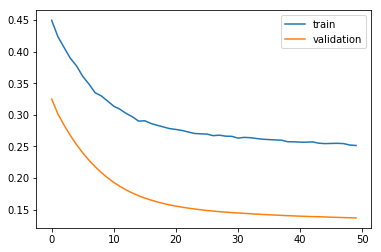

In [8]:
visualize.plot_loss(history)

# Results

In [9]:
# select last 30 days of test data (30 records)
test_X = ts_data.test_X[-30:]
test_Y = ts_data.test_y[-30:]

In [25]:
test_Y[:,0]
# [print(x.shape) for x in test_X]

array([ 0.14 , -0.17 ,  0.03 , -0.05 ,  0.18 ,  0.13 , -0.04 ,  0.06 ,
       -0.03 ,  0.01 ,  0.17 , -0.38 , -0.34 ,  0.06 , -0.16 , -0.7  ,
       -0.12 ,  0.09 ,  0.04 , -0.1  ,  0.22 , -0.26 ,  0.21 ,  0.02 ,
        0.16 ,  0.69 , -0.03 ,  0.03 , -0.09 , -0.445])

In [20]:
yhat = [float(ts_model.predict(x.reshape(1, 100, 11))) for x in test_X]

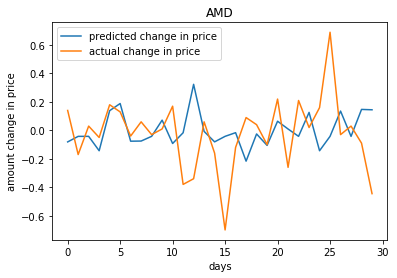

In [29]:
import matplotlib.pyplot as plt
x = [x for x in range(len(yhat))]
plt.plot(x, yhat, label='predicted change in price')
plt.plot(x, test_Y[:,0], label='actual change in price')
plt.title(ticker)
plt.xlabel('days')
plt.ylabel('amount change in price')
plt.legend()
plt.show()